In [6]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

def downscale_image(img, factor):
    """
    Downscale a 2D image by an integer factor, preserving
    both range and original dtype (e.g. uint16 → uint16).
    """
    new_shape = (img.shape[0] // factor, img.shape[1] // factor)
    down = resize(
        img,
        new_shape,
        preserve_range=True,
        anti_aliasing=True
    )
    return down.astype(img.dtype)

Original: (3340, 3440) uint16 0 65535
Downscaled: (835, 860) uint16 1263 65499


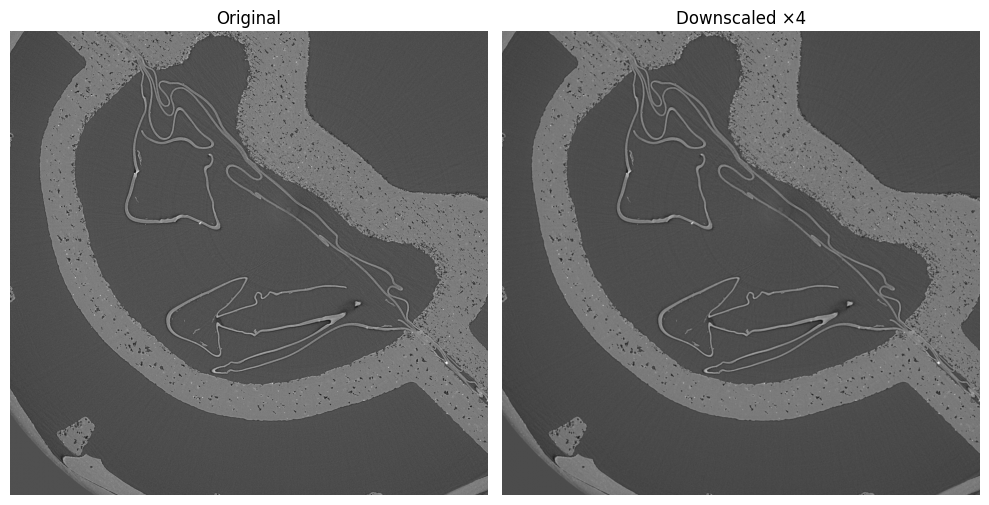

In [7]:
import os

vol_path = os.path.expanduser("~/scrollprize/data/scroll4.volpkg/volumes/dl.ash2txt.org/20231117161658")
image_path = os.path.join(vol_path, "00050.tif")

downscale_factor = 4

# load
orig = imread(image_path)

# downscale
down = downscale_image(orig, downscale_factor)

# inspect dtype and value range
print("Original:", orig.shape, orig.dtype, orig.min(), orig.max())
print("Downscaled:", down.shape, down.dtype, down.min(), down.max())

# visualize side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(orig, cmap="gray")
axs[0].set_title("Original")
axs[0].axis("off")
axs[1].imshow(down, cmap="gray")
axs[1].set_title(f"Downscaled ×{downscale_factor}")
axs[1].axis("off")
plt.tight_layout()
plt.show()


Loaded shapes: [(3340, 3440), (3340, 3440), (3340, 3440), (3340, 3440)]
Z-reduced shape: (3340, 3440) dtype: float64 range: 0.0 – 65535.0
Downscaled shape: (835, 860) dtype: float64 range: 5966.492422329098 – 65229.72239101954


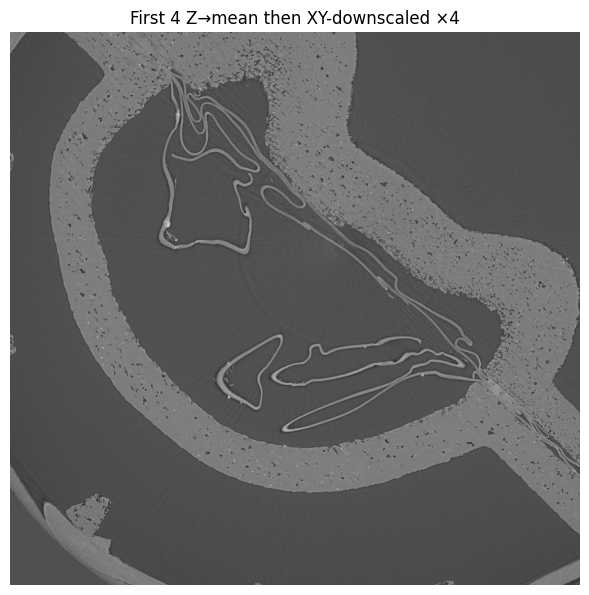

In [14]:
import os
import glob
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# ——— Parameters ———
vol_path         = os.path.expanduser(
    "~/scrollprize/data/scroll4.volpkg/volumes/dl.ash2txt.org/20231117161658"
)
downscale_factor = 4

# ——— 1) Load only the first 4 TIFFs ———
tif_paths = sorted(glob.glob(os.path.join(vol_path, "*.tif")))[:4]
imgs = [imread(p) for p in tif_paths]
print("Loaded shapes:", [im.shape for im in imgs])

# ——— 2) Z-reduce by taking the mean of the 4 slices ———
z_reduced = np.mean(np.stack(imgs, axis=0), axis=0)
print("Z-reduced shape:", z_reduced.shape, "dtype:", z_reduced.dtype,
      "range:", z_reduced.min(), "–", z_reduced.max())

# ——— 3) XY-downscale that single slice ———
xy_ds = resize(
    z_reduced,
    (z_reduced.shape[0] // downscale_factor,
     z_reduced.shape[1] // downscale_factor),
    preserve_range=True,
    anti_aliasing=True
).astype(z_reduced.dtype)
print("Downscaled shape:", xy_ds.shape, "dtype:", xy_ds.dtype,
      "range:", xy_ds.min(), "–", xy_ds.max())

# ——— 4) Plot the result ———
plt.figure(figsize=(6, 6))
plt.imshow(xy_ds, cmap="gray",
           vmin=z_reduced.min(), vmax=z_reduced.max())
plt.title(f"First 4 Z→mean then XY-downscaled ×{downscale_factor}")
plt.axis("off")
plt.tight_layout()
plt.show()


In [19]:
import os
import torch
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor
from skimage.io import imread
import matplotlib.pyplot as plt
import shutil

# 0) Paths
orig_tif = os.path.expanduser(
    "~/scrollprize/data/scroll4.volpkg/volumes/dl.ash2txt.org/20231117161658/03000.tif"
)
tmp_input = "./single_case"
tmp_output = "./single_case_results"
case_name  = "scroll"   # nnUNet case prefix

# 1) Prepare single‐file folder
os.makedirs(tmp_input, exist_ok=True)
os.makedirs(tmp_output, exist_ok=True)

dst = os.path.join(tmp_input, f"{case_name}_00000_0000.tif")
if os.path.exists(dst):
    os.remove(dst)
# use symlink; swap to shutil.copy2 if you prefer an actual copy
os.symlink(orig_tif, dst)

print("Input ready at:", dst)

# 2) Load model
predictor = nnUNetPredictor(
    tile_step_size=0.5,
    use_gaussian=True,
    use_mirroring=True,
    perform_everything_on_device=True,
    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    verbose=False,
    verbose_preprocessing=False,
    allow_tqdm=True
)
predictor.initialize_from_trained_model_folder(
    "../models/nnUNetTrainerV2__nnUNetPlans__2d",
    use_folds=(0,),
    checkpoint_name="checkpoint_best.pth"
)

# 3) Run inference on that one file
probs = predictor.predict_from_files(
    tmp_input,
    tmp_output,
    save_probabilities=True,
    overwrite=False,
    num_processes_preprocessing=1,
    num_processes_segmentation_export=1,
    folder_with_segs_from_prev_stage=None,
    num_parts=1,
    part_id=0
)

Input ready at: ./single_case/scroll_00000_0000.tif
There are 1 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict
overwrite was set to False, so I am only working on cases that haven't been predicted yet. That's 1 cases.


/home/marcel/miniconda3/envs/mask_2d_tif_volume/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.

Predicting scroll_00000:
perform_everything_on_device: True


100%|██████████| 16/16 [00:01<00:00,  9.82it/s]


sending off prediction to background worker for resampling and export
done with scroll_00000


/home/marcel/miniconda3/envs/mask_2d_tif_volume/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:

# 4) Load & plot the result
out_mask = imread(os.path.join(tmp_output, f"{case_name}_00000_0000.tif"))
plt.figure(figsize=(6,6))
plt.imshow(out_mask, cmap="gray")
plt.title("Prediction for 03000.tif")
plt.axis("off")
plt.show()


In [20]:
probs

[None]

In [1]:
!pip install tiffile

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [13]:
import tifffile
import numpy as np
import matplotlib.pyplot

mask = tifffile.imread('01562.tif')
unique_vals = np.unique(test_slice)

print(f"Unique values in mask: {unique_vals}")
print(f"Mask shape: {mask.shape}")
print(f"Mask dtype: {mask.dtype}")

Unique values in mask: [0 1]
Mask shape: (3340, 3440)
Mask dtype: uint16


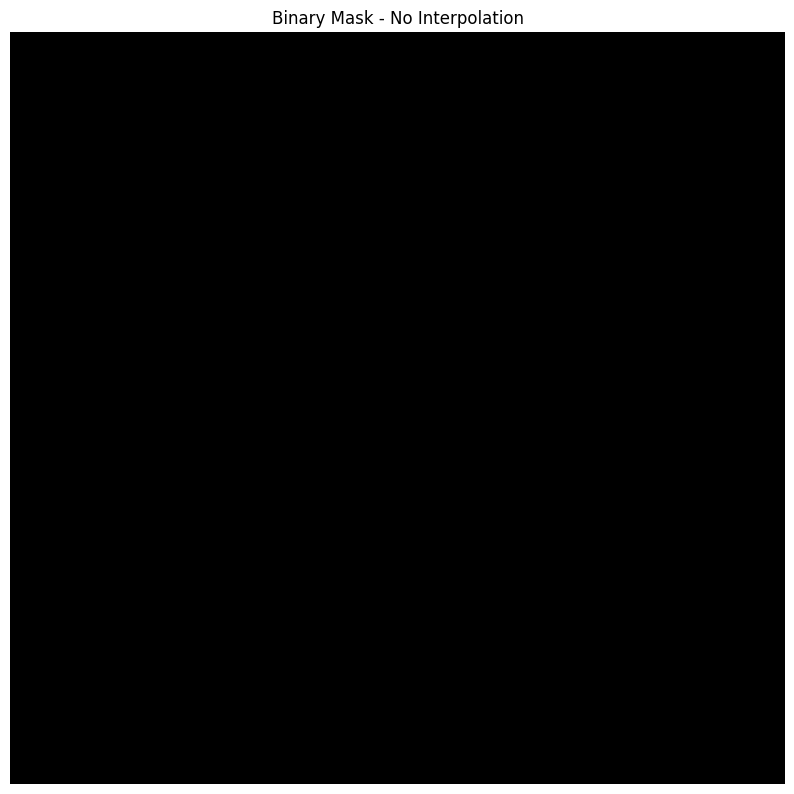

In [14]:
# Create scaled version for visualization (0→0, 1→255)
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
plt.title('Binary Mask - No Interpolation')
plt.axis('off')
plt.show()